In [1]:
import math
import random
from typing import Any

import matplotlib.pyplot as plt
import pandas as pd

from pysorteddict import SortedDict

sorted_dict_lens = [100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]


def setup(sorted_dict_len: int, seed: float = math.pi) -> SortedDict:
    random.seed(seed)
    d = SortedDict()
    for _ in range(sorted_dict_len):
        d[random.random()] = random.random()
    return d


def _plot(df: pd.DataFrame, *, alpha: float, logy: bool, yunit: str) -> Any:
    fig, ax = plt.subplots()
    df.plot(
        alpha=alpha,
        ax=ax,
        logx=True,
        logy=logy,
        xlabel="Sorted Dictionary Length",
        xlim=(sorted_dict_lens[0] // 10, sorted_dict_lens[-1] * 10),
        ylabel="Average Execution Time",
    )
    ax.grid(which="major", linewidth=0.5, linestyle=":")
    ax.grid(which="minor", axis="y", linewidth=0.0625, linestyle="-")
    ax.minorticks_on()
    ax.legend(prop={"family": "JetBrains Mono"})
    # The warning about setting labels without setting ticks can be ignored. The plot isn't interactive.
    ax.set_yticklabels(f"{label.get_text()} {yunit}" for label in ax.get_yticklabels())
    plt.show()
    return fig


def plot(df: pd.DataFrame, *, alpha: float = 0.7, logy: bool = False, name: str = "", yunit: str = "s"):
    for style in ["light", "dark"]:
        with plt.style.context(f"{style}.mplstyle", after_reset=True):
            fig = _plot(df, alpha=alpha, logy=logy, yunit=yunit)
            fig.savefig(f"../../docs/_static/images/perf-{name}-{style}.svg")

# `contains`

In [2]:
df = pd.DataFrame(index=sorted_dict_lens, columns=["0.00 in d", "0.33 in d", "0.67 in d", "1.00 in d"])
for i, sorted_dict_len in enumerate(sorted_dict_lens):
    d = setup(sorted_dict_len)
    for j, key in enumerate([0.00, 0.33, 0.67, 1.00]):
        %timeit -v bench key in d
        df.iat[i, j] = bench.average * 1e9

275 ns ± 15.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
322 ns ± 29.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
248 ns ± 13 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
227 ns ± 9.66 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
341 ns ± 5.66 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
410 ns ± 6.91 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
427 ns ± 27.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
408 ns ± 20.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
484 ns ± 41.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
443 ns ± 11 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
464 ns ± 17.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
442 ns ± 36.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
608 ns ± 40.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
681

,0.00 in d,0.33 in d,0.67 in d,1.00 in d
100,275.392076,321.71901,248.073011,227.021579
1000,340.866456,410.481139,427.493275,407.779179
10000,483.973509,442.762406,464.107689,441.659004
100000,607.601627,680.963346,535.982755,581.507176
1000000,670.332016,818.65474,714.700062,587.654795
10000000,857.301591,1029.72286,909.608846,734.555234


/tmp/ipykernel_44871/1982810410.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(f"{label.get_text()} {yunit}" for label in ax.get_yticklabels())
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.


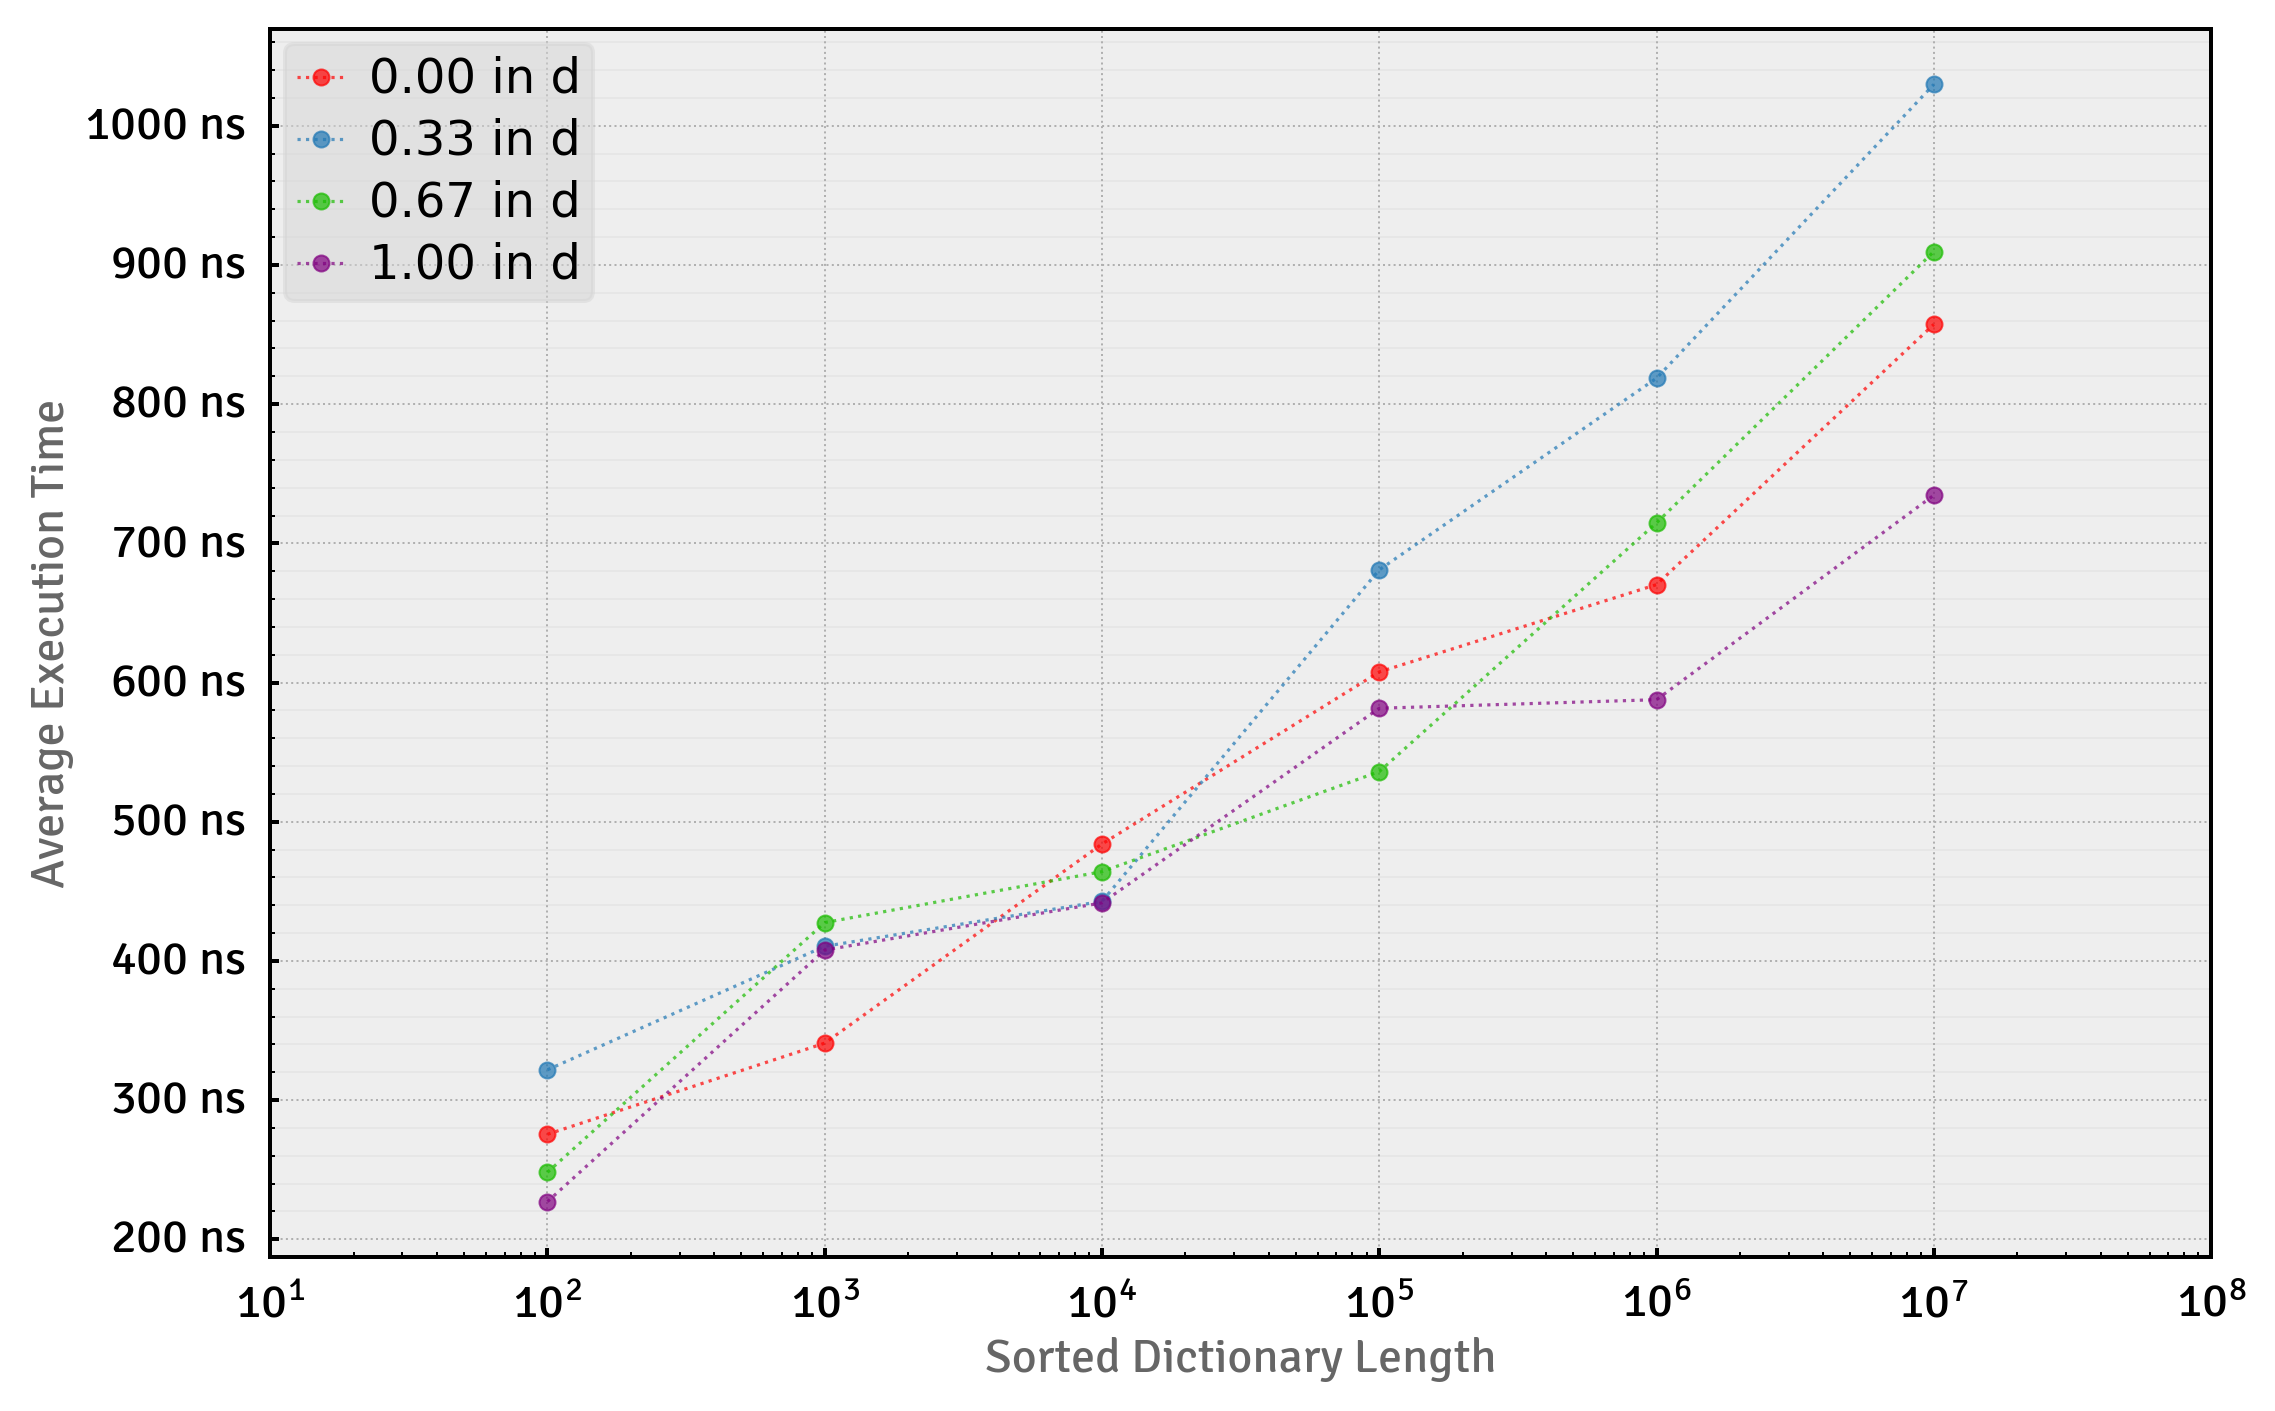

findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
/tmp/ipykernel_44871/1982810410.py:37: UserWarning

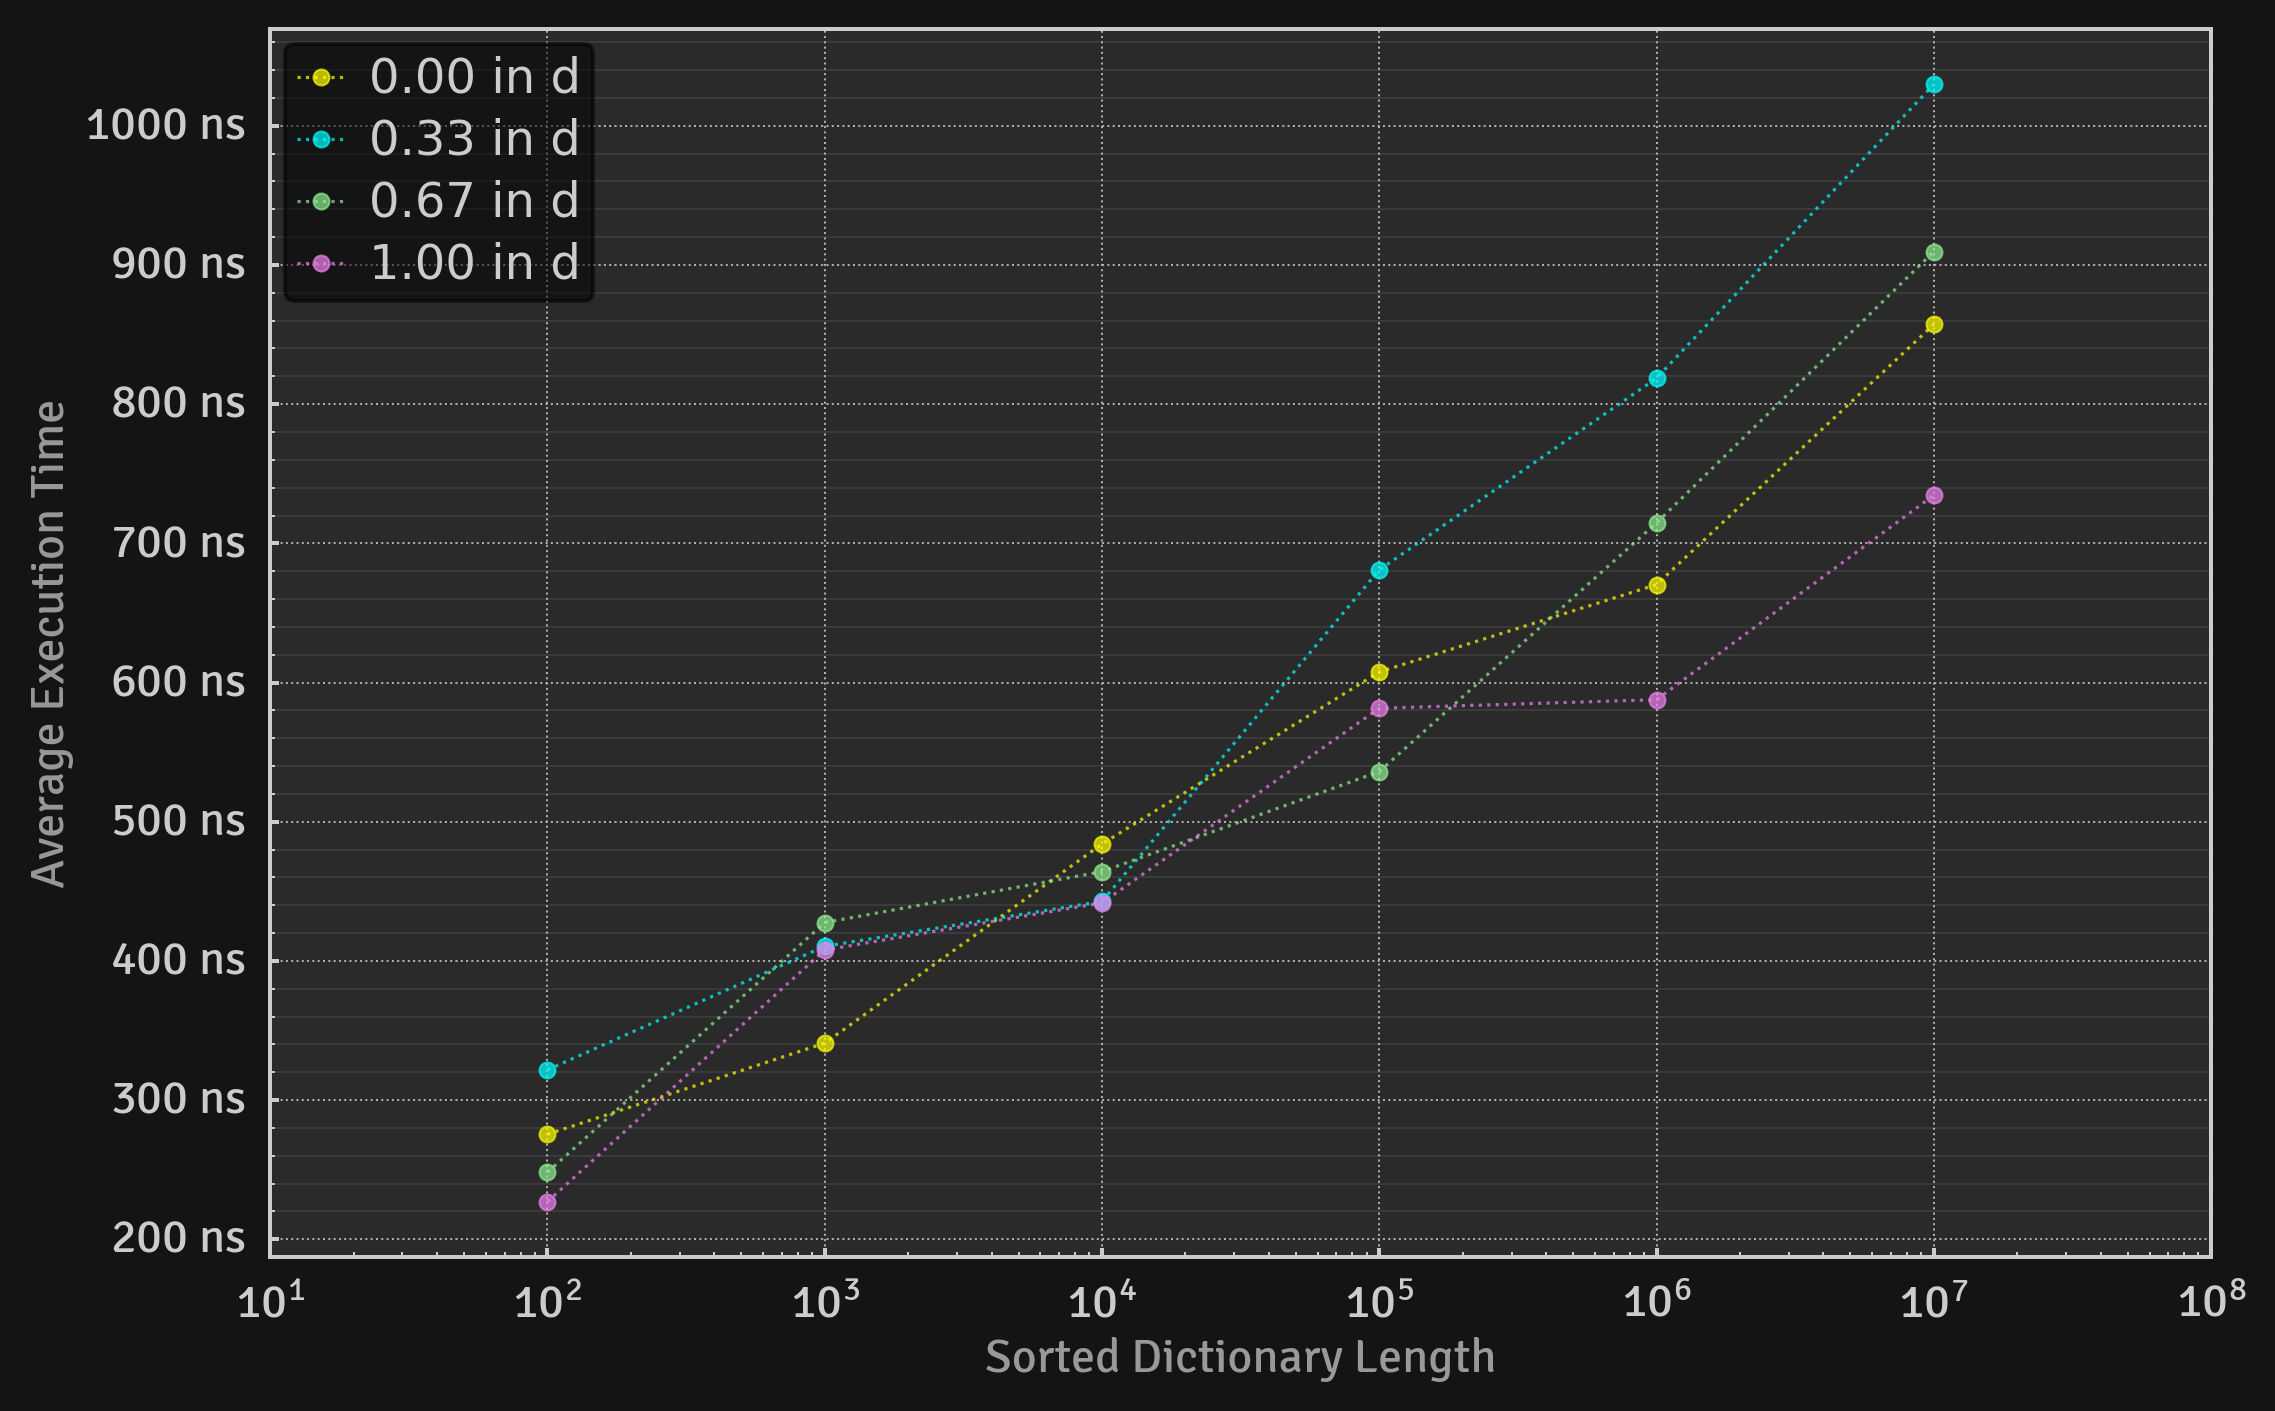

findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.
findfont: Font family 'JetBrains Mono' not found.


In [3]:
display(df)
plot(df, name="contains", yunit="ns")

# `setitem`

In [ ]:
def set_del(d: SortedDict, keys: list[float]):
    for key in keys:
        d[key] = None
    for key in keys:
        del d[key]


keys_lens = [33, 67, 100]
df = pd.DataFrame(index=sorted_dict_lens, columns=[f"set_del(d, keys_{keys_len})" for keys_len in keys_lens])
for i, sorted_dict_len in enumerate(sorted_dict_lens):
    for j, keys_len in enumerate(keys_lens):
        d = setup(sorted_dict_len)
        keys = [random.random() for _ in range(keys_len)]
        %timeit -v bench set_del(d, keys)
        df.iat[i, j] = bench.average * 1e6

In [ ]:
display(df)
plot(df, name="setitem", yunit="μs")

# `iter`

In [ ]:
df = pd.DataFrame(index=sorted_dict_lens, columns=["for _ in d: pass"])
for i, sorted_dict_len in enumerate(sorted_dict_lens):
    d = setup(sorted_dict_len)
    %timeit -v bench for _ in d: pass
    df.iloc[i] = bench.average

In [ ]:
display(df)
plot(df, logy=True, name="iter")